In [2]:
# Import packages (will need to change java environment code)
import pandas as pd
import numpy as np
import json
import os
import pyterrier as pt
from pyterrier.measures import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
os.environ["JAVA_HOME"] = "/home/rickmart/.conda/envs/terrier"
os.environ["JVM_PATH"] = "/home/rickmart/.conda/envs/terrier/lib/jvm/lib/server/libjvm.so"
os.environ["PATH"] = f"/home/rickmart/.conda/envs/terrier/bin:" + os.environ["PATH"]
if not pt.started():
    pt.init()

/tmp/ipykernel_3081687/846703735.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():
Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_3081687/846703735.py:17: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [3]:
# read in 50,000 rows of recipe data
df = pd.read_json("project_data.json", lines=True)

In [4]:
# rename columns for pyterrier
corpus = df.rename(columns={'docid': 'docno', 'full_doc': 'text'})
corpus['docno'] = corpus['docno'].astype(str)

In [5]:
# create and save the index: only run the first time
# indexer = pt.IterDictIndexer("./terrier_index")
# index_ref = indexer.index(corpus.to_dict(orient='records'))

In [6]:
index_ref = pt.IndexRef.of("./terrier_index/data.properties")

In [7]:
index = pt.IndexFactory.of(index_ref)

In [8]:
# Load in the csv contains the 40 queries
queries = pd.read_csv("SI_650_project_queries.csv")
queries["qid"] = queries["qid"].astype(int)

In [9]:
# Load in the labeled relevance data for each query and combine it into one dataframe
file_names = [f"SI650_relevance_data_labeling - label_data_q{i}.csv" for i in range(1, 41)]

dfs = []

for file in file_names:
    df = pd.read_csv( "labeled_relevance_data/" + file)
    qid = int(file.split("_q")[1].split(".")[0])
    df["qid_file"] = qid
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

In [10]:
# Create recipe features for the L2R system
recipe_features = corpus[['docno', 'ingredients', 'directions']].copy()
recipe_features['docno'] = recipe_features['docno'].astype(int)
recipe_features['num_ingredients'] = recipe_features['ingredients'].apply(lambda x: len(str(x).split()))
recipe_features['directions_length'] = recipe_features['directions'].apply(lambda x: len(str(x).split()))

In [11]:
# Helper function to create query feature
def extract_skill(query):
    if query.lower().startswith('easy'):
        return 0
    elif query.lower().startswith('difficult'):
        return 1
    else:
        return 0

In [12]:
# Create query features for the L2R system
combined_df['query_length'] = combined_df['query'].apply(lambda x: len(x.split()))
combined_df['contains_healthy'] = combined_df['query'].str.contains("healthy").astype(int)
combined_df['skill'] = combined_df['query'].apply(extract_skill)

In [13]:
# Merge query features and recipe features into one dataframe
train_df = combined_df.merge(recipe_features, on='docno', how='left')

In [14]:
# Create an interaction feature
def ingredient_overlap(row):
    q_terms = set(row['query'].split())
    d_terms = set(str(row['ingredients']).split())
    return len(q_terms & d_terms)

train_df['ingredient_overlap'] = train_df.apply(ingredient_overlap, axis=1)

In [15]:
# Initialize bm25 model and add it to the feature dataframe
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25_scores = bm25.transform(queries)
bm25_scores['docno'] = bm25_scores['docno'].astype(int)
bm25_scores['qid'] = bm25_scores['qid'].astype(int)

train_df = train_df.merge(bm25_scores[['qid', 'docno', 'score']],on=['qid', 'docno'],how='left').rename(columns={'score': 'bm25_score'})

/tmp/ipykernel_3081687/231951789.py:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index, wmodel="BM25")


In [16]:
# Split the data into test, train, and validation sets
unique_qids = train_df['qid'].unique()
train_qids, test_qids = train_test_split(unique_qids, test_size=0.2, random_state=42)
train_qids, val_qids = train_test_split(train_qids, test_size=0.25, random_state=42)

train_df_split = train_df[train_df['qid'].isin(train_qids)]
val_df_split   = train_df[train_df['qid'].isin(val_qids)]
test_df_split  = train_df[train_df['qid'].isin(test_qids)]

feature_cols = ['num_ingredients', 'directions_length', 'query_length','contains_healthy', 'skill', 'ingredient_overlap', 'bm25_score']

X_train = train_df_split[feature_cols]
y_train = train_df_split['rel']
group_train = train_df_split.groupby('qid').size().tolist()

X_val = val_df_split[feature_cols]
y_val = val_df_split['rel']
group_val = val_df_split.groupby('qid').size().tolist()

X_test = test_df_split[feature_cols]
y_test = test_df_split['rel']
group_test = test_df_split.groupby('qid').size().tolist()

In [17]:
# Initialize the XGBRanker model, fit the model, and predict on the test data
model = xgb.XGBRanker(objective='rank:ndcg', learning_rate=0.1, max_depth=6, n_estimators=600)

model.fit(X_train, y_train, group=group_train, eval_set=[(X_val, y_val)], eval_group=[group_val], verbose=True)

y_pred = model.predict(X_test)

[0]	validation_0-ndcg@32:0.75158
[1]	validation_0-ndcg@32:0.78448
[2]	validation_0-ndcg@32:0.79670
[3]	validation_0-ndcg@32:0.78803
[4]	validation_0-ndcg@32:0.79439
[5]	validation_0-ndcg@32:0.79092
[6]	validation_0-ndcg@32:0.79980
[7]	validation_0-ndcg@32:0.80335
[8]	validation_0-ndcg@32:0.80627
[9]	validation_0-ndcg@32:0.80503
[10]	validation_0-ndcg@32:0.80494
[11]	validation_0-ndcg@32:0.80337
[12]	validation_0-ndcg@32:0.80612
[13]	validation_0-ndcg@32:0.80961
[14]	validation_0-ndcg@32:0.80921
[15]	validation_0-ndcg@32:0.80849
[16]	validation_0-ndcg@32:0.80926
[17]	validation_0-ndcg@32:0.81062
[18]	validation_0-ndcg@32:0.81058
[19]	validation_0-ndcg@32:0.80955
[20]	validation_0-ndcg@32:0.81012
[21]	validation_0-ndcg@32:0.81085
[22]	validation_0-ndcg@32:0.81050
[23]	validation_0-ndcg@32:0.81165
[24]	validation_0-ndcg@32:0.81370
[25]	validation_0-ndcg@32:0.81349
[26]	validation_0-ndcg@32:0.80808
[27]	validation_0-ndcg@32:0.80808
[28]	validation_0-ndcg@32:0.80803
[29]	validation_0-ndcg@3

In [18]:
# Generate relevance test metrics
test_eval_df = test_df_split.copy()
test_eval_df['pred'] = y_pred

ndcgs = []
maps = []

for qid, group in test_eval_df.groupby('qid'):
    y_true = group['rel'].values
    y_score = group['pred'].values
    

    if len(np.unique(y_true)) == 1:
        continue
    
    ndcgs.append(ndcg_score([y_true], [y_score], k=10))
    
    maps.append(average_precision_score((y_true >= 4).astype(int), y_score))
    

results = {'NDCG@10': np.mean(ndcgs),'MAP': np.mean(maps)}

In [19]:
results

{'NDCG@10': np.float64(0.8404339803809483),
 'MAP': np.float64(0.7000032912166254)}

## Feature Importance

In [30]:
importance_dict = model.get_booster().get_score(importance_type='gain')
importance_dict

{'num_ingredients': 0.07278553396463394,
 'directions_length': 0.057966504245996475,
 'query_length': 0.09510182589292526,
 'contains_healthy': 0.06832408159971237,
 'skill': 0.09049499034881592,
 'ingredient_overlap': 0.10078710317611694,
 'bm25_score': 0.11162102967500687}

In [33]:
importance_df = (
    pd.DataFrame(list(importance_dict.items()), columns=["feature", "importance"]))

/tmp/ipykernel_3081687/2922628769.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3081687/2922628769.py:2: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


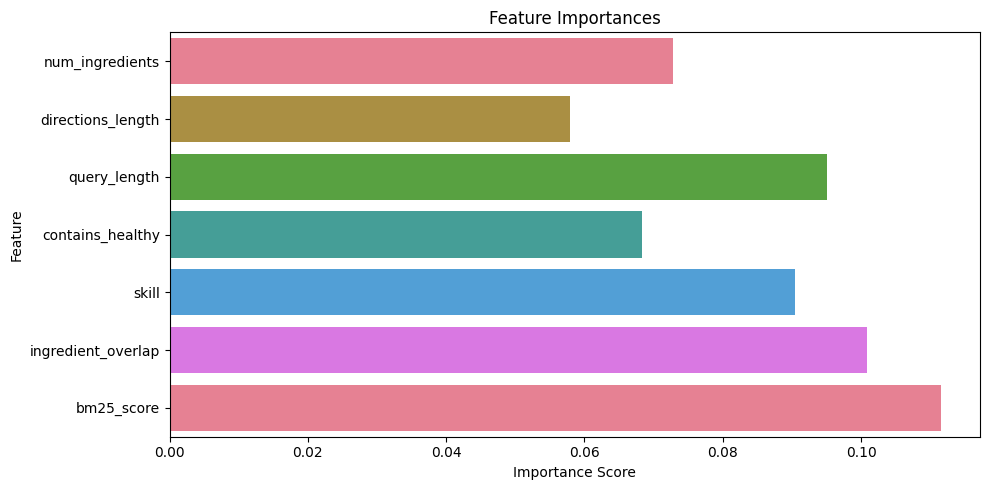

In [38]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=importance_df,
    x="importance",
    y="feature",
    palette=sns.color_palette("husl"),
    orient="h"
)

plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Running the system

In [21]:
def compute_overlap(query, ingredients_string):
    q_terms = set(query.lower().split())
    d_terms = set(str(ingredients_string).lower().split())
    return len(q_terms & d_terms)

In [22]:
def make_features(query, bm25_results):
    df = bm25_results.copy()
    df["docno"] = df["docno"].astype(int)
    df = df.merge(recipe_features, on='docno', how='left')
    
    df['query_length'] = len(query.split())
    df['contains_healthy'] = int("healthy" in query.lower())
    df['skill'] = extract_skill(query)

    df['ingredient_overlap'] = df.apply(lambda row: compute_overlap(query, row['ingredients']),axis=1)
    df = df.rename(columns={'score': 'bm25_score'})

    return df
    

In [23]:
def l2r_search(query, topk=50):
    bm25_results = bm25.search(query)[['qid', 'docno', 'score']]
    bm25_results = bm25_results.head(topk)
    
    feature_df = make_features(query, bm25_results)

    X = feature_df[feature_cols]
    feature_df['l2r_score'] = model.predict(X)

    reranked = feature_df.sort_values('l2r_score', ascending=False)

    return reranked


In [24]:
l2r_search("difficult rice beef")

,qid,docno,bm25_score,ingredients,directions,num_ingredients,directions_length,query_length,contains_healthy,skill,ingredient_overlap,l2r_score
2,1,1905,13.468030,1 stick oleo 1 c. raw rice 2 cans beef consomme,Brown rice in a little butter. Add rest of but...,11,31,3,0,1,2,-0.511886
7,1,7593,13.136609,1 pkg. beef stew meat 1 - 2 cans (small) mushr...,Simmer beef stew meat in crock pot or skillet....,28,30,3,0,1,2,-0.829904
20,1,32427,12.697088,1 can Campbell's beef broth 1 can Campbell's b...,"Mix all ingredients in large dish, except pork...",32,26,3,0,1,2,-0.968321
8,1,37341,13.121753,1 medium onion 1 c. rice 1 stick butter 2 cans...,Melt butter in skillet. Chop onion. Add onion ...,13,27,3,0,1,2,-0.976734
3,1,36589,13.316238,1 lb. ground beef 1 c. canned tomatoes 1 c. co...,Cook beef until brown. Drain and add remaining...,15,14,3,0,1,2,-1.203409
5,1,8220,13.177558,1 c. white rice 1 can beef broth (bouillon) 1 ...,Place white rice in casserole dish. Put in the...,18,32,3,0,1,2,-1.242799
48,1,11097,12.250423,"3/4 lb. boneless chuck, cut in thin slices 1 l...","Saute beef, onion and garlic in oil until meat...",43,28,3,0,1,2,-1.281911
4,1,40519,13.237368,1 c. rice 1 can consomme beef soup 1 can beef ...,Cover and bake at 375° for 45 minutes.,19,8,3,0,1,2,-1.332214
45,1,41476,12.273383,"1 1/2 lb. round steak, cut in thin strips 2 Tb...","Brown beef in oil. Stir in onion, rice, beef b...",46,43,3,0,1,2,-1.368654
6,1,46916,13.153537,1 lb. ground beef 6 green peppers 1 c. rice 1 ...,Cook rice; mix hamburger and rice. Cut top off...,14,30,3,0,1,2,-1.385510
